In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re  # for re.split

import torch

In [2]:
with open('moby_dick_10_chapters.txt','r') as f:
    moby = f.read()

# Split into words by blanks and newlines
moby = re.split('[ \n]', moby)
# Remove punctuation and space from left and right of each word.
# Convert all characters to lower case
moby = [word.strip(',. ;:?!+"\'').lower() for word in moby]
# Remove emtpy string 
moby = [word for word in moby if word != '' and word != ' ']
print(f'Text has {len(moby)} words.')
      
vocab = list(set(moby))
vocab_size = len(vocab)

print(f'Vocabulary has {vocab_size} words.')

Text has 19588 words.
Vocabulary has 4410 words.


In [3]:
# make tri-grams
trigrams = [(moby[i], moby[i+1], moby[i+2]) for i in range(len(moby) - 2)]

# Convert words into vocab indices
trigrams_indices = [(vocab.index(w0), vocab.index(w1), vocab.index(w2))
                    for (w0, w1, w2) in trigrams]
len(trigrams_indices)

19586

In [4]:
# Convert indices into one_hot indicator variables
def make_one_hot(index):
    one_hot = np.zeros(len(vocab))
    one_hot[index] = 1
    return one_hot

X = [(make_one_hot(i0), make_one_hot(i1))
     for (i0, i1, _) in trigrams_indices]
T = [i2 for (_, _, i2) in trigrams_indices]

X = np.array(X)  # (N, 2, 97)
X = X.reshape(-1, 2 * len(vocab))

T = np.array(T)  # .reshape(-1, 1)
X.shape, T.shape

((19586, 8820), (19586,))

In [5]:
X = torch.tensor(X.astype(np.float32)).reshape((-1, X.shape[1]))  # remove the channel dimension
T = torch.tensor(T)
X.shape, T.shape

(torch.Size([19586, 8820]), torch.Size([19586]))

In [6]:
ntrain = int(X.shape[0] * 0.8)
Xtrain = X[:ntrain, :]
Ttrain = T[:ntrain]
Xtest = X[ntrain:, :]
Ttest = T[ntrain:]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

(torch.Size([15668, 8820]),
 torch.Size([15668]),
 torch.Size([3918, 8820]),
 torch.Size([3918]))

Before we used convolutional units to learn embedding.  Instead, we can define an embedding network and apply it twice, once to each word.

Epoch 20 error 6.11463
Epoch 40 error 4.63408
Epoch 60 error 3.34388
Epoch 80 error 2.50745
Epoch 100 error 2.00150
Epoch 120 error 1.69062
Epoch 140 error 1.45574
Epoch 160 error 1.30210
Epoch 180 error 1.18310
Epoch 200 error 1.09728


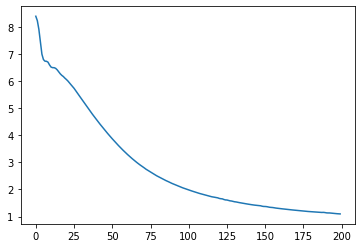

In [7]:
ndim_embedding = 8
learning_rate = 0.01
n_epochs = 200

embedder = torch.nn.Sequential(
    torch.nn.Linear(vocab_size, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, ndim_embedding),
    torch.nn.Tanh())
    
nnet = torch.nn.Sequential(
    torch.nn.Linear(2 * ndim_embedding, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, vocab_size))


error_trace = []
loss_F = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(embedder.parameters()) +
                             list(nnet.parameters()), lr=learning_rate)


embedder.train()
nnet.train()

for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    # Y = nnet(Xtrain)
    embed0 = embedder(Xtrain[:, :vocab_size])
    embed1 = embedder(Xtrain[:, vocab_size:])
    Y = nnet(torch.cat((embed0, embed1), 1))

    error = loss_F(Y, Ttrain)
    error.backward()
    optimizer.step()
    
    error_trace.append(error)
    if (epoch + 1) % (max(1, n_epochs // 10)) == 0 or epoch == n_epochs-1:
        print(f'Epoch {epoch+1} error {error:.5f}')

embedder.eval()
nnet.eval()

plt.figure(1)
plt.clf()
plt.plot(error_trace)

In [12]:
embed0 = embedder(Xtrain[:, :vocab_size])
embed1 = embedder(Xtrain[:, vocab_size:])
Ytrain = nnet(torch.cat((embed0, embed1), 1))
Ytrain_classes = torch.argmax(Ytrain, axis=1)
percent_correct = float((Ytrain_classes == Ttrain).sum()) / len(Ttrain) * 100
print(f'Got {percent_correct:.1f} of training samples correct')

embed0 = embedder(Xtest[:, :vocab_size])
embed1 = embedder(Xtest[:, vocab_size:])
Ytest = nnet(torch.cat((embed0, embed1), 1))
Ytest_classes = torch.argmax(Ytest, axis=1)
percent_correct = float((Ytest_classes == Ttest).sum()) / len(Ttest) * 100
print(f'Got {percent_correct:.1f} of training samples correct')

Got 70.2 of training samples correct
Got 5.6 of training samples correct


In [13]:
import pandas

for_dataframe = []
for i in range(0, 10 * 50, 9):
    for_dataframe.append([trigrams[i], vocab[Ttrain[i]], vocab[Ytrain_classes[i]]])
print('Train Data')
pandas.DataFrame(for_dataframe, columns=('the trigram', 'third word', 'predicted third word'))

Train Data


,the trigram,third word,predicted third word
0,"(chapter, 1, loomings)",loomings,loomings
1,"(mind, how, long)",long,long
2,"(my, purse, and)",and,and
3,"(shore, i, thought)",thought,thought
4,"(and, see, the)",the,the
5,"(is, a, way)",way,mighty
6,"(spleen, and, regulating)",regulating,regulating
7,"(growing, grim, about)",about,about
8,"(damp, drizzly, november)",november,november
9,"(myself, involuntarily, pausing)",pausing,pausing


In [14]:
for_dataframe = []
for i in range(0, 10 * 50, 9):
    for_dataframe.append([trigrams[ntrain + i], vocab[Ttest[i]], vocab[Ytest_classes[i]]])
print('Test Data')
pandas.DataFrame(for_dataframe, columns=('the trigram', 'third word', 'predicted third word'))

Test Data


,the trigram,third word,predicted third word
0,"(we, sail, with)",with,with
1,"(he, slowly, answered)",answered,be
2,"(sir?'—'soon, enough, for)",for,to
3,"(passenger, ha, jonah)",jonah,at
4,"(calls, away, the)",the,to
5,"(with, ye,'—he, says,—'the)","says,—'the",with
6,"(pay, now, for)",for,just
7,"(if, it, were)",were,were
8,"(in, this, history)",history,disobeying
9,"(ere, the, craft)",craft,book


<Figure size 5760x1440 with 0 Axes>

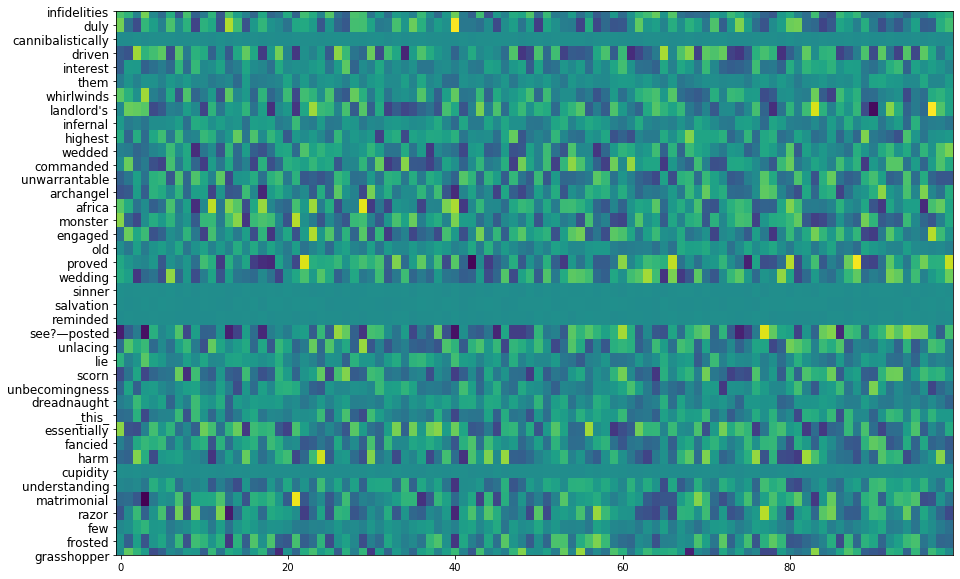

In [26]:
plt.figure(figsize=(80,20))
weights = embedder[0].weight.detach()
n0, n1 = (0, 40)
plt.figure(figsize=(15, 10))
plt.imshow(weights.T[n0:n1], interpolation='nearest')
plt.axis('auto')
plt.yticks(range(n1 - n0), vocab[n0:n1], fontsize=12);